# Altitude: An Observational Study ⛰️

Hypothesis: Long range field goals have a greater change of conversion at altitude than sea-level.

In [103]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import mysql.connector
import itertools
import dtale
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
from datetime import datetime as dt
from util.data import clean, get_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load & Clean

In [104]:
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
df = get_data(cnx, 'g.seas<=2019', xp=False, base='raw_6_cat')
df = clean(df, dropna=False)
df

,fkicker,good,dist,year,seasons,temperature,home_team,stadium,team,XP,...,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,,,,,
2166,AD-0800,1,38,2000,17,73,BUF,Ralph Wilson Stadium,TEN,0,...,1,10,1,0,0,1,0,1,0.764708,765
2185,AD-0800,1,27,2000,17,73,BUF,Ralph Wilson Stadium,TEN,0,...,1,10,1,0,0,1,0,1,0.807721,766
4565,AD-0800,1,36,2000,17,80,TEN,Adelphia Coliseum,TEN,0,...,1,13,0,0,1,0,0,5,NaN,767
8564,AD-0800,1,24,2000,17,61,PIT,Three Rivers Stadium,TEN,0,...,0,16,1,0,0,1,1,1,0.842837,768
8628,AD-0800,1,40,2000,17,61,PIT,Three Rivers Stadium,TEN,0,...,0,16,1,0,0,1,1,1,0.871516,769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862982,ZG-0050,1,30,2019,3,66,ARI,State Farm Stadium,ARI,0,...,0,0,0,0,0,0,0,1,0.826709,62
865338,ZG-0050,1,21,2019,3,66,ARI,State Farm Stadium,ARI,0,...,0,11,0,0,0,0,0,2,0.858217,63
868268,ZG-0050,1,22,2019,3,43,SEA,CenturyLink Field,ARI,0,...,1,7,1,0,0,1,0,1,1.000000,64


## Explore

There seems to be a slight up-tick for long range kicks (+45 yards), but the sample size is quite small, as indicated by the confidence bands.

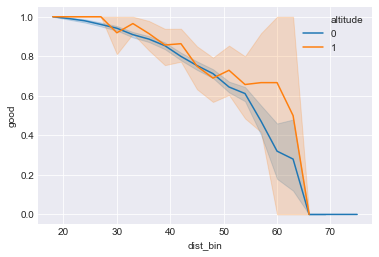

In [105]:
df_ = df.copy()
df_['dist_bin'] = 3*round(df_['dist']/3)
sns.lineplot(x='dist_bin', y='good', hue='altitude', data=df_)

## Matching

* Mahanalobis distance with radius matching

We filter for away kicks at greater than 45 yards. We choose away kicks because only Denver home games are at altitude, so need to avoid biasing for Broncos kicker. We drop the away_game column to allow for inversion of the covariance matrix.

In [112]:
df_longaway = df[(df['away_game']==1) & (df['dist']>=45)].drop(['fkicker', 'home_team', 'stadium', 'team', 'XP', 'away_game'], axis=1)
df_longaway['form'] = df_longaway['form'].fillna(method='bfill')
print(df_longaway['altitude'].value_counts())
df_longaway

0    2415
1      99
Name: altitude, dtype: int64


,good,dist,year,seasons,temperature,age,altitude,humid,wind,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,
20774,1,46,2000,17,54,38,0,0,9,0,0,0,0,1,0.710344,779
32219,1,50,2000,17,30,38,0,0,7,0,1,1,0,6,0.961555,795
479437,0,63,2011,1,61,24,0,0,0,0,0,1,0,1,0.605990,2
513552,1,51,2011,1,70,24,0,0,0,0,0,1,0,2,0.730446,24
519075,0,45,2012,2,68,25,0,0,9,0,0,0,0,2,1.000000,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827414,1,55,2018,2,45,23,0,1,5,0,0,1,0,6,1.000000,32
844674,1,47,2019,3,56,24,0,1,3,0,0,1,1,1,0.813096,52
846996,1,50,2019,3,70,24,0,0,0,0,0,1,0,1,0.771461,56


We find paired kicks for altitude and sea-level with replacement using mahalanobis distance.

In [127]:
from util.matching import match

df_longaway['altitude'] = df_longaway['altitude'].astype(bool)
matches = match(df_longaway.drop('good', axis=1), t='altitude', distance='mahalanobis', method='with_replacement', caliper=2)
control_idx = [idx for idx in matches.index if matches.loc[idx,:].sum()] # controls that have a treatment match
treatment_idx = [idx for idx in matches.columns if matches[idx].sum()] # treatments that have a control match
df_matched = df_longaway.loc[control_idx + treatment_idx, :]
df_matched

,good,dist,year,seasons,temperature,age,altitude,humid,wind,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,
765232,1,47,2017,2,68,22,False,0,5,0,0,0,0,1,0.795713,11
221737,0,53,2005,10,83,32,False,0,7,0,0,0,0,1,0.795256,407
221767,1,48,2005,10,83,32,False,0,7,0,0,0,0,1,0.650664,408
354476,1,46,2008,13,82,35,False,0,11,0,0,0,0,1,0.851486,509
484862,1,45,2011,16,80,38,False,0,0,0,0,0,0,1,0.767790,576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272473,0,54,2006,7,64,28,True,0,3,0,0,0,0,1,0.804800,236
272532,1,47,2006,7,64,28,True,0,3,0,0,0,0,1,0.658472,237
423132,1,54,2009,10,57,31,True,0,6,0,0,0,0,1,0.698193,340


In [128]:
df_alt = df_matched.loc[df_matched['altitude']==1, :]
df_sea = df_matched.loc[df_matched['altitude']==0, :]
print(len(df_alt), 'at altitude.', len(df_sea), 'at sea-level.')

76 at altitude. 378 at sea-level.


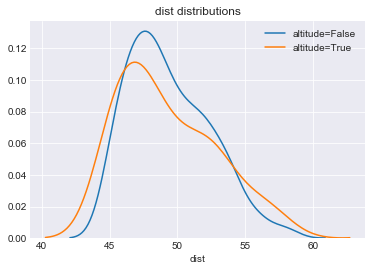

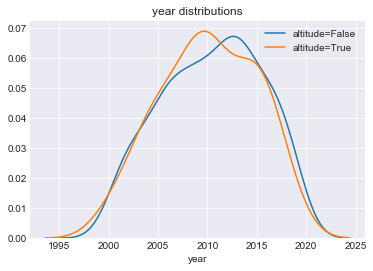

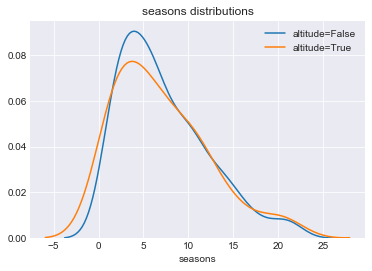

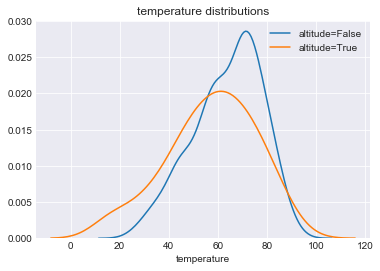

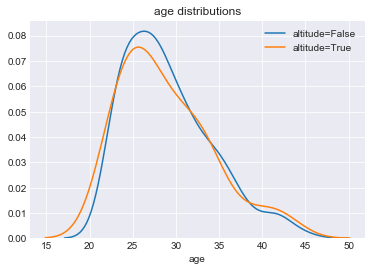

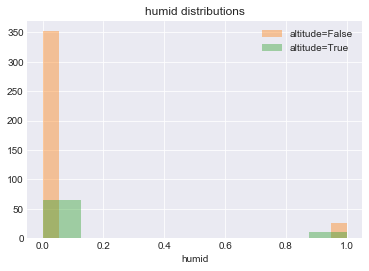

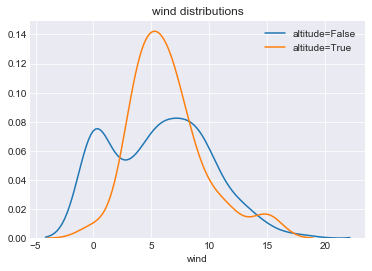

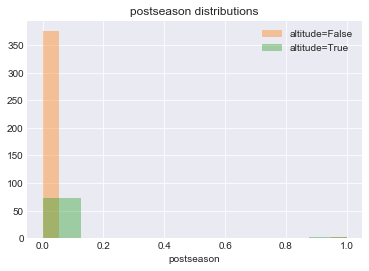

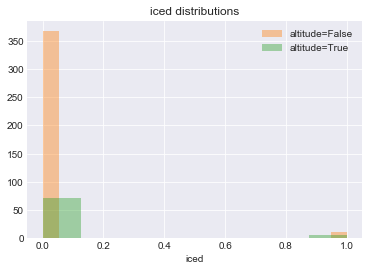

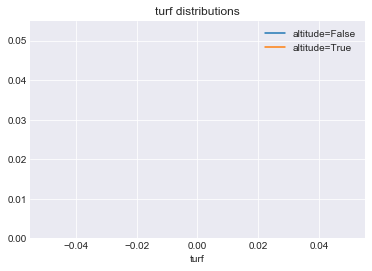

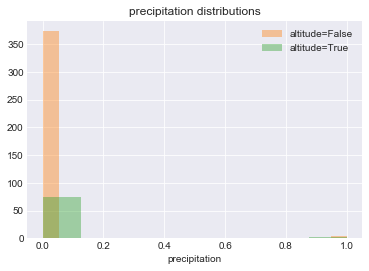

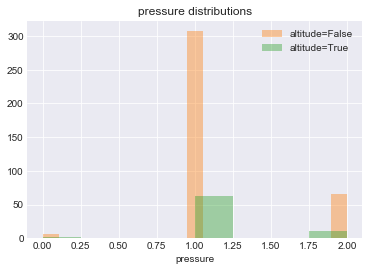

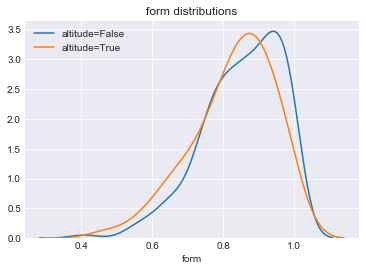

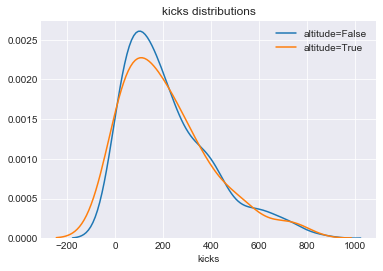

In [129]:
from util.matching import covariate_dists

covariate_dists(df_matched.drop('good', axis=1), on='altitude')

Our caliper controls how alike our covariate distributions are, how can we assess the likeness? Kolmogorov-Smirnov tests.
Out of the box, the KS test only works for continuous variables, so we need to address ordinal or binary variables.

## TODO: Choose caliper based on maximising some kind of average histogram similarity measure.

In [143]:
from util.matching import ks_test

ks = ks_test(df_matched.drop('good', axis=1), on='altitude')
ks

## Model

We work within a Bayesian framework, setting a prior distribution on the true population proportion and update the prior after our observations. The Beta-Binomial conjugacy makes this process relatively pain-free. Our prior mean is the sample population proportion (all kicks).

In [99]:
from scipy.stats import beta
p_hat = df[df['dist']>=45]['good'].mean()
# beta_ = 2
# alpha_ = int(round(p_hat*beta_/(1-p_hat)))
alpha_ = 12
beta_ = int(round(alpha_*(1-p_hat)/p_hat))
print(f'alpha: {alpha_}, beta: {beta_}')

alpha: 12, beta: 6


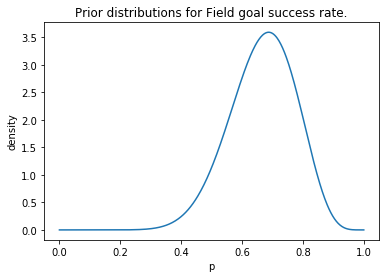

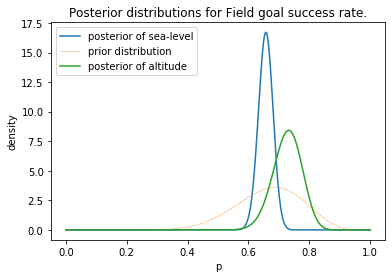

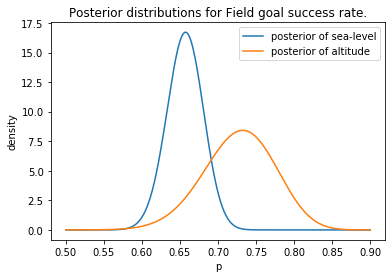

In [100]:
from util.bayes import BetaBinomial

control = BetaBinomial(alpha_, beta_, 'sea-level')
treatment = BetaBinomial(alpha_, beta_, 'altitude')
control.plot_prior(show=True)
plt.cla()

control.observe(df_sea['good'])
treatment.observe(df_alt['good'])

control.plot_posterior(prior=False)
treatment.plot_posterior(show=True, prior=True)

# zoom in
x = np.linspace(0.5,0.9,500)
control.plot_posterior(x, prior=False, show=False)
treatment.plot_posterior(x, prior=False, show=True)

samples = 20000
samples_posterior_sea = control.sample(samples)
samples_posterior_alt = treatment.sample(samples)

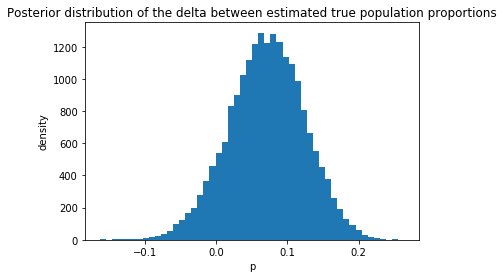

90% likely that altitude has a greater true population proportion of converted field goals.
0.07 is the median difference, with 50% credible interval of (0.0,0.14).


In [101]:
posterior_diff = samples_posterior_alt - samples_posterior_sea

plt.hist(posterior_diff, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of the delta between estimated true population proportions')
plt.show()
gt = int((samples_posterior_alt>samples_posterior_sea).mean()*100)
print(f'{gt}% likely that altitude has a greater true population proportion of converted field goals.')

from scipy.stats import bayes_mvs
alpha = 0.5
center, _, _ = bayes_mvs(posterior_diff, alpha=alpha)
print(f'{round(center.statistic,2)} is the median difference, with {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')

We are sometimes interested in relative increase. For instance, the difference between 0.6 and 0.7 is relatively larger than the difference between 0.7 and 0.8.
We calculate relative increase of our treatment (altitude) over control (sea-level) using our posterior distributions.

54 % likely relative lift is greater than 10%.
0.11 is the median relative lift, with 50% credible interval of (0.0,0.22).


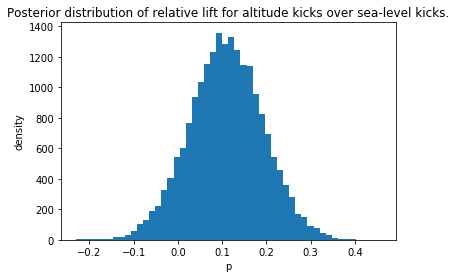

In [102]:
posterior_relative = (samples_posterior_alt-samples_posterior_sea)/samples_posterior_sea
plt.hist(posterior_relative, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of relative lift for altitude kicks over sea-level kicks.')
print(int((posterior_relative>0.1).mean()*100), r'% likely relative lift is greater than 10%.')

alpha = 0.5
center, _, _ = bayes_mvs(posterior_relative, alpha=alpha)
print(f'{round(center.statistic,2)} is the median relative lift, with {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')